In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
# import multiprocessing as mp
from HAST import HAST
import cv2
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] = './R-4.3.1'

In [2]:
n_clusters = 5
dataset = '151672'

In [ ]:
# read data
file_fold = './Data/spatialLIBD/' + str(dataset) #please replace 'file_fold' with the download path
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
img = cv2.imread(file_fold + '/' + str(dataset) + '_full_image.tif')

In [ ]:
# define model
model = HAST.HAST(adata, device=device, image=img)

In [5]:
# train model
# adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [02:05<00:00,  4.77it/s]


Optimization finished for ST data!
Final model weights saved at /home/zcy/HAST-main/weights/Mouse_Brain_Anterior/weights.pth


In [5]:
adata = model.test()

In [6]:
# set radius to specify the number of neighbors considered during refinement
radius = 40

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from HAST.utils import clustering


if tool == 'mclust':
      clustering(adata, n_clusters, radius=radius, method=tool, refinement=True, random_state=42) #For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [7]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [8]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
FMI = metrics.fowlkes_mallows_score(adata.obs['domain'], adata.obs['ground_truth'])
NMI = metrics.normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['FMI'] = FMI
adata.uns['ARI'] = ARI
adata.uns['NMI'] = NMI

print('Dataset:', dataset)
print('ARI:', ARI)
print('FMI:', FMI)
print('NMI:', NMI)

/tmp/ipykernel_304676/2369655791.py:8: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['FMI'] = FMI


Dataset: 151672
ARI: 0.6974720382831348
FMI: 0.7813623057439413
NMI: 0.7169282502438038


[<Axes: title={'center': 'Ground_truth'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'ARI=0.70, FMI=0.78, NMI=0.72'}, xlabel='spatial1', ylabel='spatial2'>]

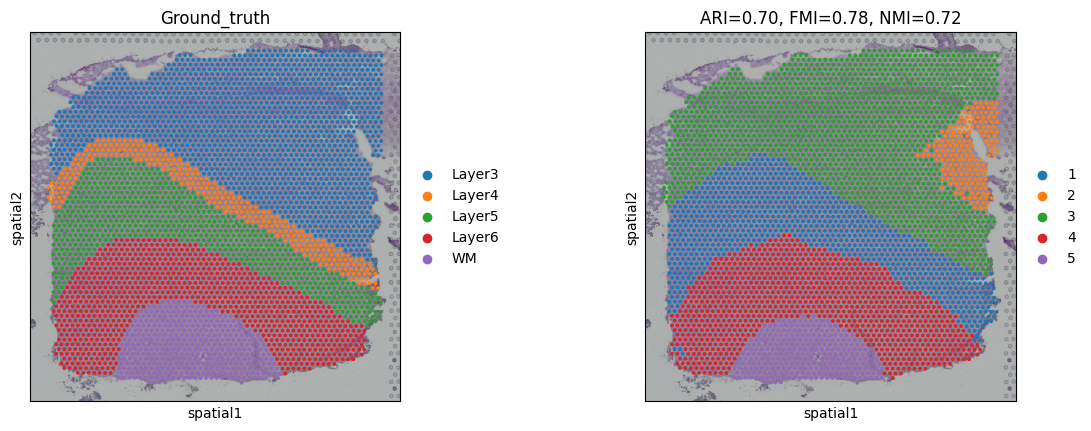

In [9]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground_truth", "ARI=%.2f, FMI=%.2f, NMI=%.2f"%(ARI,FMI,NMI)],
              show=False)